# Visual odometry
We can try to create a visual odometry part using feature matching and tracking between consecutive frames.
We use modified SIFT with RootSIFT to get the feature descriptors and KLT Tracker to get the odometry.

[WinError 2] The system cannot find the file specified: '.. -- So we can move the notebooks folder to the root of the project'
c:\Users\PArco\OneDrive\-\Curriculums\Remy Robotics\reconstruction



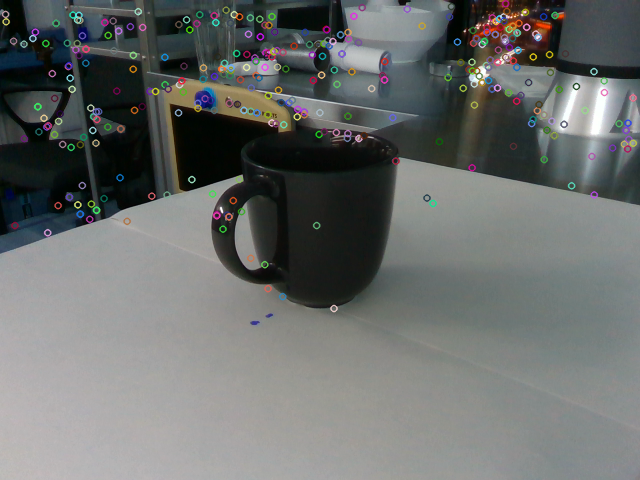
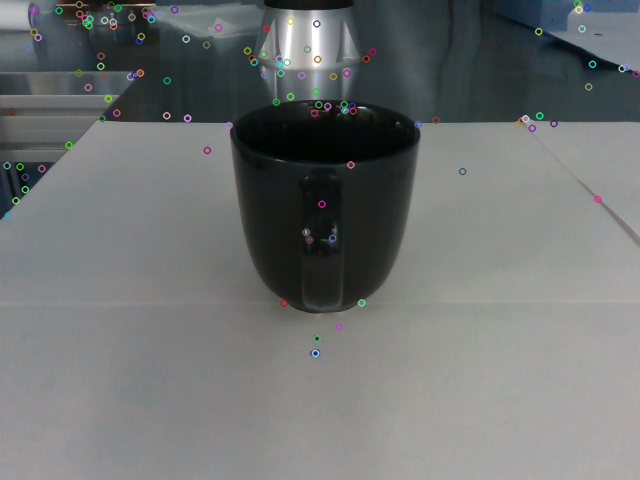


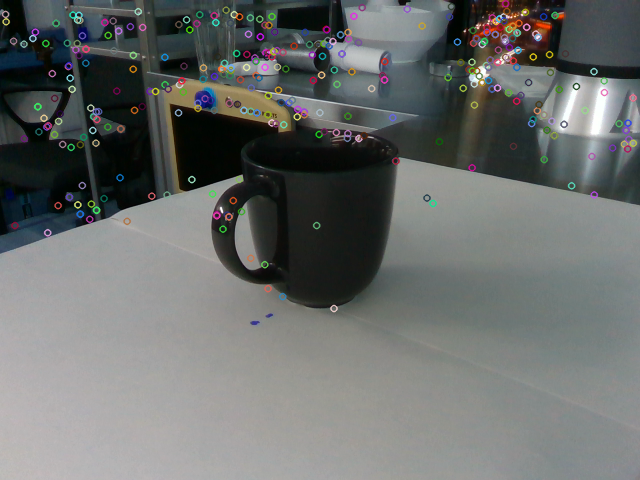
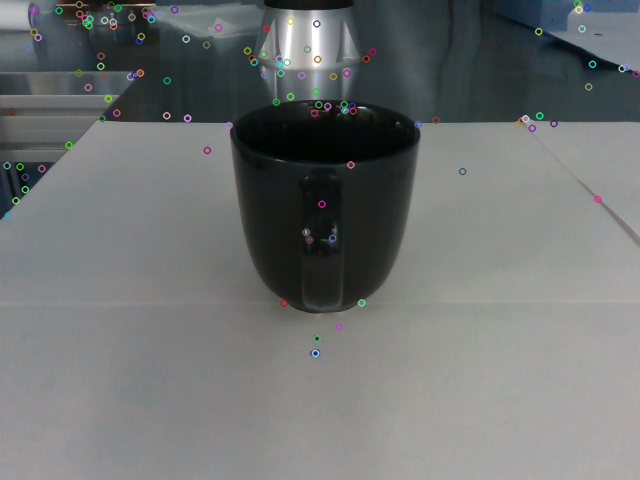

[[ 2.89202614e+00  7.20832905e-01 -1.14927595e+03]
 [-1.70863198e-01  1.98133499e+00 -3.05260129e+01]
 [ 1.71281123e-03  9.96939531e-05  1.00000000e+00]]
4


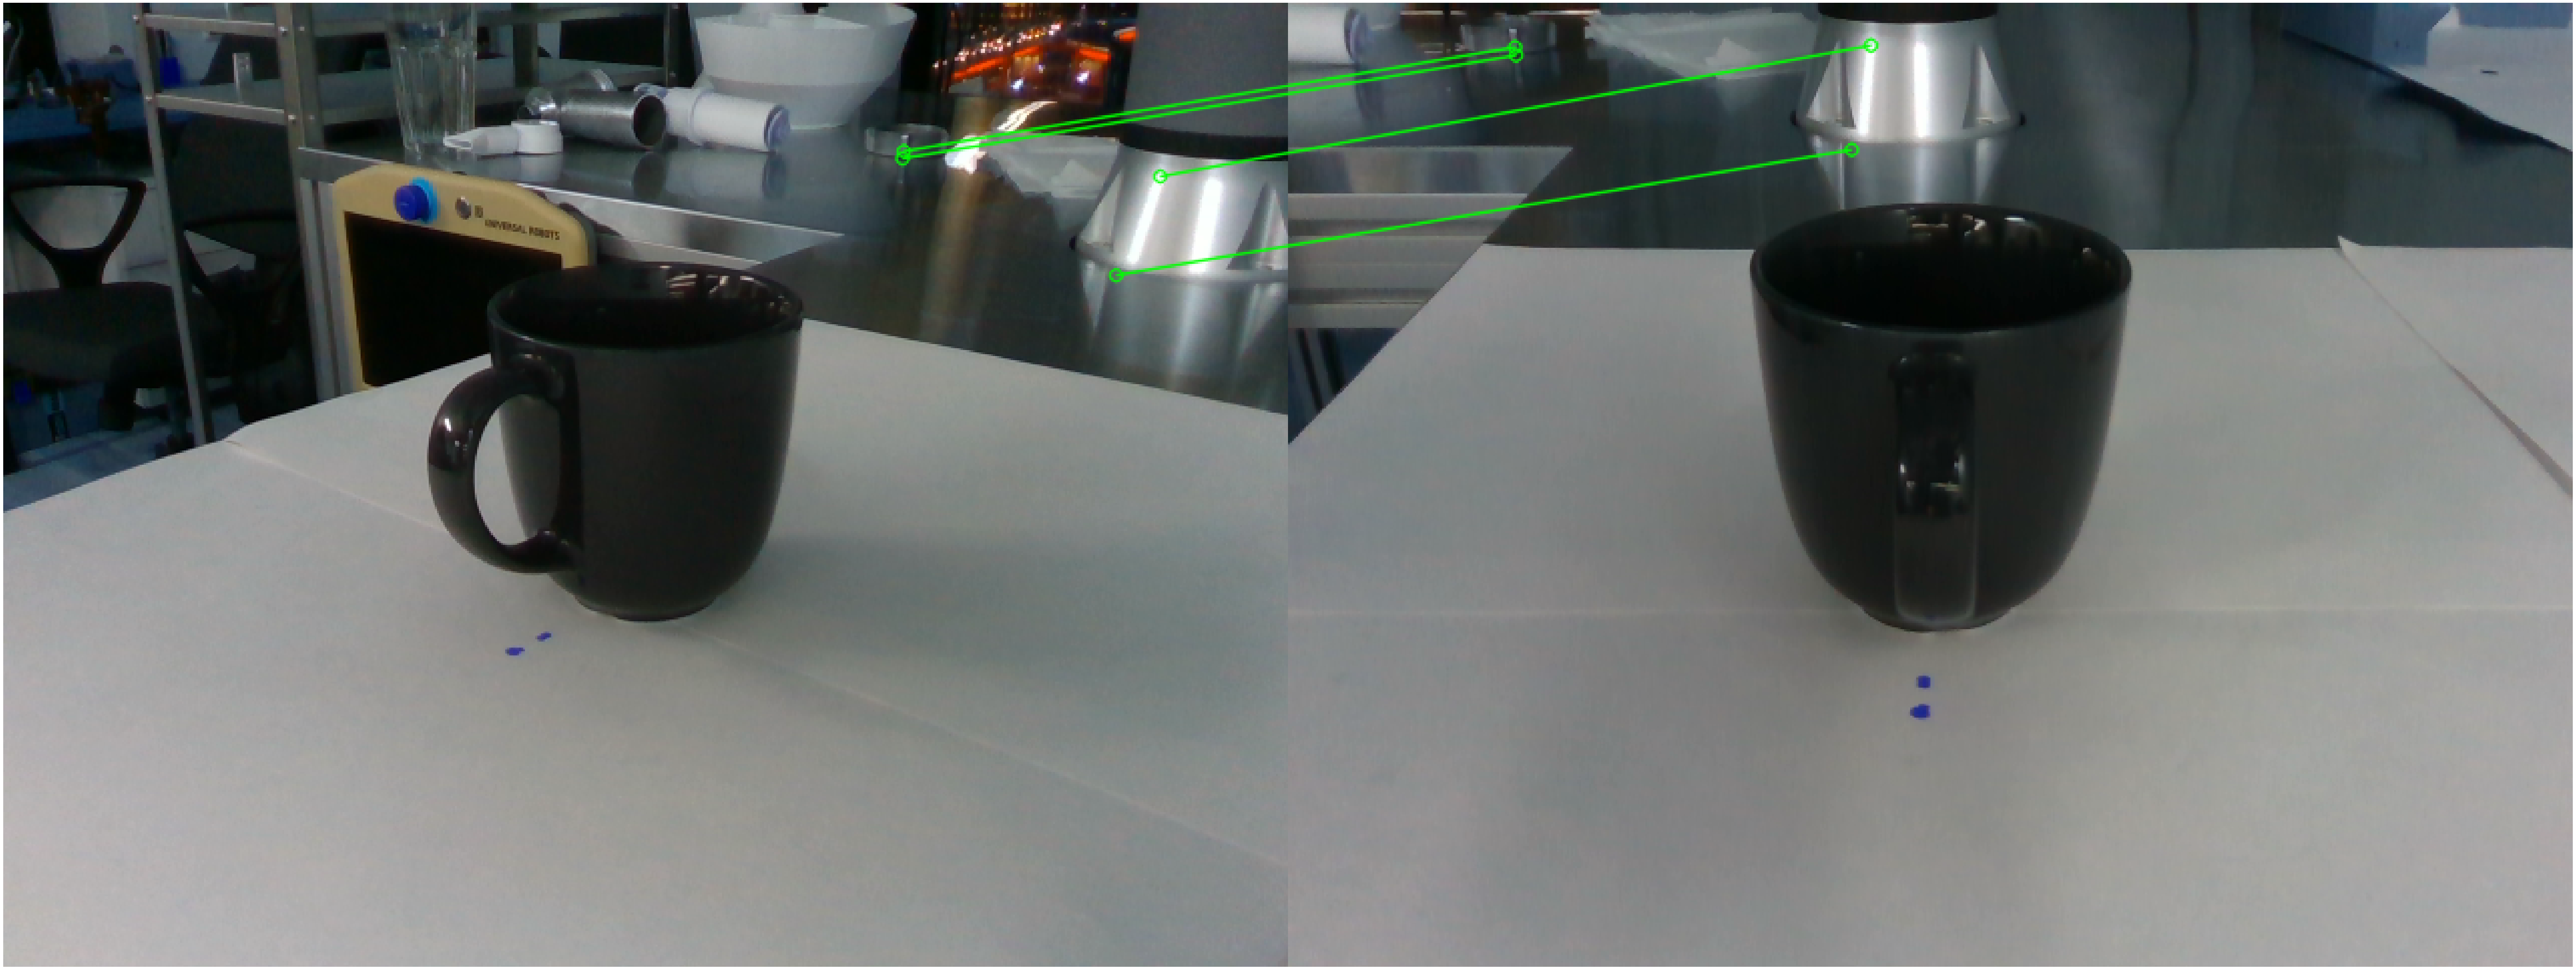

In [4]:

%cd .. -- So we can move the notebooks folder to the root of the project
import cv2
import numpy as np
from reconstruction.dataset import Dataset
import ipyplot
from matplotlib import pyplot as plt

dataset = Dataset.read("data/3d-scans-cap-black-glossy-ha-2019-02-27T16_06_29")
source_img = cv2.imread(dataset.frames[100].color_file)
target_img = cv2.imread(dataset.frames[110].color_file)

feature_extractor = cv2.SIFT_create()

def extract_features(image):
    eps = 1e-7
    # compute SIFT descriptors
    (kps, descs) = feature_extractor.detectAndCompute(image, None)
    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
        return ([], None)

    # apply the Hellinger kernel by first L1-normalizing and taking the
    # square-root
    descs /= (descs.sum(axis=1, keepdims=True) + eps)
    descs = np.sqrt(descs)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)


source_keypoints, source_descriptors = extract_features(source_img)
target_keypoints, target_descriptors = extract_features(target_img) 

img = cv2.drawKeypoints(source_img, source_keypoints, None)
img2 = cv2.drawKeypoints(target_img, target_keypoints, None)
ipyplot.plot_images([img, img2], img_width=300)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(source_descriptors, target_descriptors, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

src_pts = np.float32([ source_keypoints[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ target_keypoints[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print(M)
matchesMask = mask.ravel().tolist()
h, w = source_img.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
print(len(pts))
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(source_img, source_keypoints, target_img, target_keypoints, good, None, **draw_params)
plt.figure(figsize=(100,100))
plt.imshow(img3)
plt.axis(False)
plt.show()

# Normalize for Esential Matrix calaculation
# pts_l_norm = cv2.undistortPoints(np.expand_dims(pts_l, axis=1), cameraMatrix=K_l, distCoeffs=None)
# pts_r_norm = cv2.undistortPoints(np.expand_dims(pts_r, axis=1), cameraMatrix=K_r, distCoeffs=None)

# E, mask = cv2.findEssentialMat(pts_l_norm, pts_r_norm, focal=1.0, pp=(0., 0.), method=cv2.RANSAC, prob=0.999, threshold=3.0)
# points, R, t, mask = cv2.recoverPose(E, pts_l_norm, pts_r_norm)

# M_r = np.hstack((R, t))
# M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
